# SFINCS Model setup

We want to combine data from the SRTM of resolution 30 m with data by Lin et al. for the river widths.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

import hydromt
import hydromt_sfincs
from hydromt.config import configread
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

logger = setuplog("prepare data catalog", log_level=10)

2024-03-12 10:31:04,410 - prepare data catalog - log - INFO - HydroMT version: 0.9.4


**Steps followed in this notebook to build your SFINCS model:**
<ol> 
<li> Open SfincsModel class, set data library and output folder </li>
<li> Specify characteristics of the wanted grid </li>
<li> Load in wanted elevation datasets </li>
<li> Make mask of active and inactive cells </li>
<li> Update mask with water level and outflow boundary cells</li>
<li> Add spatially varying roughness data</li>
<li> Make subgrid derived tables</li>
<li> Add spatially varying infiltration data</li>
<li> Add water level time-series as forcing</li>
<li> Add an upstream discharge time-series as forcing</li>
<li> Add spatially varying rainfall data</li>
<li> Add weirfile</li>
<li> Add observation points</li>
<li> Add observation lines</li>
<li> Show model</li>
<li> Save all files</li>
</ol> 

### 1. Initialize SfincsModel class, set data library and output folder:

In [2]:
model_root = Path(r"model")
data_libs = [
    Path(r"data/1_static/data_static_garissa.yml"),
    #Path(r"data/2_forcing/data_forcing.yml"),
]
base_root = Path(r"model/base")

data_catalog = hydromt.DataCatalog(data_libs=data_libs, logger=logger)

2024-03-12 10:31:04,425 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_garissa.yml


### 2. Specify characteristics of the wanted grid and generate grid:

In [3]:
# bbox = [36.6209722222222140, -3.1540277777777708,
#          41.5604166666666472, 0.4798611111111084]
# region = {"bbox": bbox}

model = SfincsModel(root=base_root, data_libs=data_libs, mode="w+", logger=logger)

2024-03-12 10:31:04,514 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_garissa.yml
2024-03-12 10:31:04,527 - prepare data catalog - log - DEBUG - Appending log messages to file c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\base\hydromt.log.
2024-03-12 10:31:04,527 - prepare data catalog - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


{'mmax': 100, 'nmax': 600, 'dx': 0.001, 'dy': 0.0005, 'x0': 39.65, 'y0': -0.6, 'rotation': 28, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 4326}


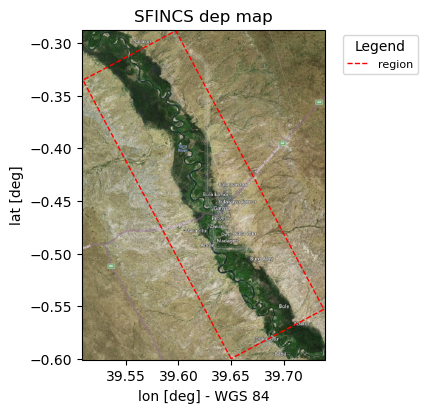

In [5]:
# model.setup_grid_from_region(
#     region=region,
#     res=0.01,
#     crs=4326,
#     hydrography_fn="srtm30"
#     )

# model.setup_grid(
#     x0=39.65, #672889606923,
#     y0=-0.60, #45884215259317,
#     dx=0.001,
#     dy=0.0005,
#     nmax=600,
#     mmax=100,
#     rotation=28,
#     epsg=4326,
# )

# import pyproj
# transformer = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:32636', always_xy=True)

# # Transform the coordinates
# x0, y0 = transformer.transform(39.65, -0.60)

# x0 = int(x0)
# y0 = int(y0)
# print(x0, y0)

# print(type(x0))

# Now set up the grid with the transformed coordinates
model.setup_grid(
    x0=572229.0472239251,
    y0=-66023.34909525415,
    dx=100.0,  # Fill in your value for dx
    dy=100.0,  # Fill in your value for dy
    nmax=4,
    mmax=4,
    rotation=28,
    epsg=21097, 
)

# print(model.grid)

print(model.config)
_ = model.plot_basemap(plot_region=True, bmap="sat")

### 3. Load in wanted elevation datasets:

2024-03-12 10:29:29,280 - prepare data catalog - rasterdataset - INFO - Reading merit_hydro raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\s05e035\{variable}.tif
2024-03-12 10:29:29,495 - prepare data catalog - rasterdataset - INFO - Reading merit_hydro raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\s05e035\{variable}.tif
2024-03-12 10:29:29,522 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.509, -0.600, 39.738, -0.288] (epsg:4326))
2024-03-12 10:29:29,831 - prepare data catalog - merge - DEBUG - Reprojection method of first dataset is: bilinear
<xarray.Dataset> Size: 1MB
Dimensions:      (y: 600, x: 100)
Coordinates:
    yc           (y, x) float64 480kB -0.5995 -0.5991 ... -0.2891 -0.2886
    xc           (y, x) float64 480kB 39.65 39.65 39.65 39.65 ... 39.6 39.6 39.6
    spatial_ref  int32 4B 0
Dimensions without coordinates: y, x
Data

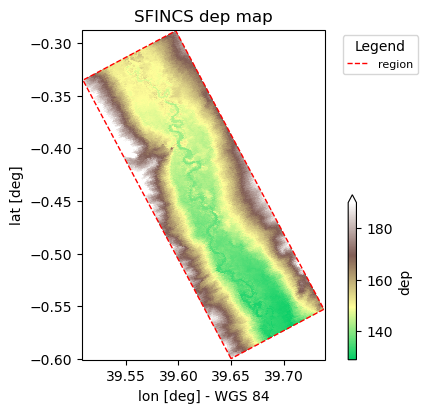

In [5]:
# Also print some statistics
dem = data_catalog.get_rasterdataset("merit_hydro")["elevtn"]

# print(dem)
# nan_count = xr.where(dem.isnull(), 1, 0).sum()
# print("Number of NaN values:", int(nan_count))
# nan_count = xr.where(dem.isnull() | (dem == dem._FillValue), 1, 0).sum()
# print("Number of NaN values including _FillValue:", int(nan_count))
# total_values = dem.size
# print("Total number of values in the DataArray:", total_values)
# print("Fraction:  ", round(float(nan_count/total_values), 1))


datasets_dep = [{"elevtn": "merit_hydro", "reproj_method": "bilinear"}]
model.setup_dep(datasets_dep=datasets_dep)


print(model.grid)

print(model.geoms)

print("Plotting")
_ = model.plot_basemap(variable="dep", plot_region=True)

### 4. Make mask of active and inactive cells:


In [6]:
model.setup_mask_active(zmin=120, reset_mask=True)
# _ = model.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

2024-03-12 10:14:04,535 - prepare data catalog - regulargrid - INFO - 0 gaps outside valid elevation range < 10.0 km2.
2024-03-12 10:14:04,537 - prepare data catalog - sfincs - INFO - Derive region geometry based on active cells.


### 5. Update mask with water level and outflow boundary cells - including use of polygons:

Performed after the river generation (5), since the river generation removes intersecting boundaries.

In [7]:
# model.setup_mask_bounds(btype="outflow", zmax=140, reset_bounds=True)

# # # Make a plot of the mask file
# _ = model.plot_basemap(variable="msk", plot_bounds=True)

### 6. Add river inflow/outflow points:

In [8]:
# # derive river from hydrography data based on a minimum river length (river_len)
# # and minimum upstream area (river_upa)
# river_len = 0.1 # km
# river_upa = 100 # km2
# river_width = 150 # m

# model.setup_river_inflow(
#     hydrography="merit_hydro", 
#     river_len=river_len, 
#     river_upa=river_upa, 
#     river_width=river_width, 
#     keep_rivers_geom=True
# )

2024-03-12 10:14:07,348 - prepare data catalog - regulargrid - DEBUG - outflow (mask=3) boundary cells reset.


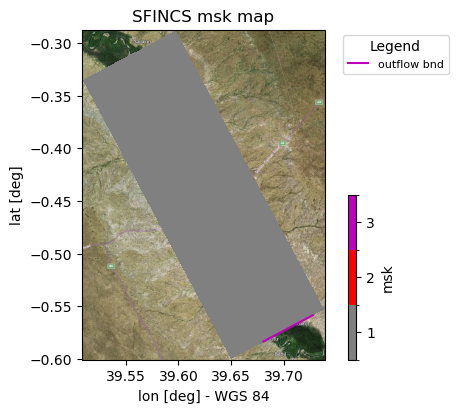

In [9]:
# Outflow boundary
model.setup_mask_bounds(btype="outflow", zmax=140, reset_bounds=True)

# Make a plot of model
# note the src points and derived river network
fig, ax = model.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

In [10]:
# gdf_riv = model.geoms["rivers_inflow"].copy()

# print(gdf_riv)

# gdf_riv["rivbed"]   = "srtm30"
# # gdf_riv["mask"]     = "grwl_mask"
# gdf_riv["manning"]  = 0.03  # manning coefficient [s.m-1/3]
# # gdf_riv[["geometry", "rivwth", "rivdph", "manning"]]

# datasets_riv = [{"centerlines": gdf_riv}]


### 7. Add spatially varying roughness data:

In [11]:
datasets_rgh = [{"lulc": "vito"}]

### 8. Make subgrid derived tables:

In [12]:
model.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_rgh=datasets_rgh,
    # datasets_riv=datasets_riv,
    nr_subgrid_pixels=1,
    # z_minimum=120,
    write_dep_tif=True,
    write_man_tif=False,
)

# uncomment to see the subgrid table variales
# sf.subgrid

# we can plot the 2D subgrid variables
_ = model.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, bmap="sat", zoomlevel=12
)

2024-03-12 10:14:12,766 - prepare data catalog - rasterdataset - INFO - Reading srtm30 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\srtm30\STRM30DEM_tana.tif
2024-03-12 10:14:12,792 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.509, -0.600, 39.738, -0.288] (epsg:4326))
2024-03-12 10:14:12,804 - prepare data catalog - rasterdataset - INFO - Reading vito raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\landuse\landuse_vito_tana1.tif
2024-03-12 10:14:12,836 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.509, -0.600, 39.738, -0.288] (epsg:4326))
2024-03-12 10:14:12,839 - prepare data catalog - dataframe - INFO - Reading  csv data from c:\Users\pjdeb\anaconda3\envs\hydromt-sfincs\lib\site-packages\hydromt_sfincs\data\lulc\vito_mapping.csv


The nodata value None is not in the reclass table.None will be used for the params.


2024-03-12 10:14:12,875 - prepare data catalog - subgrid - INFO - Number of regular cells in a block : 2000
2024-03-12 10:14:12,876 - prepare data catalog - subgrid - INFO - Number of blocks in n direction    : 1
2024-03-12 10:14:12,877 - prepare data catalog - subgrid - INFO - Number of blocks in m direction    : 1
2024-03-12 10:14:12,878 - prepare data catalog - subgrid - INFO - Grid size of flux grid            : dx=0.0009999999999999705, dy=0.0005000000000000016
2024-03-12 10:14:12,879 - prepare data catalog - subgrid - INFO - Grid size of subgrid pixels       : dx=0.0009999999999999705, dy=0.0005000000000000016
2024-03-12 10:14:12,880 - prepare data catalog - subgrid - INFO - block 1/1 -- col 0:99 | row 0:599
2024-03-12 10:14:12,948 - prepare data catalog - subgrid - WARNING - Interpolate elevation data at 60000 subgrid pixels
2024-03-12 10:14:12,990 - prepare data catalog - subgrid - WARNING - Fill manning roughness data at 60000 subgrid pixels with default values


AssertionError: NaN values in depth array

In [ ]:
model.subgrid

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

In [21]:
subgrid = data_catalog.get_rasterdataset(Path(r"model\base/subgrid/dep_subgrid.tif"))
print(subgrid)

nan_count = xr.where(subgrid.isnull(), 1, 0).sum()

print("Number of NaN values:", int(nan_count))

2024-03-12 09:20:20,948 - prepare data catalog - rasterdataset - INFO - Reading  raster data from model\base\subgrid\dep_subgrid.tif
<xarray.DataArray 'dep_subgrid' (y: 600, x: 100)> Size: 240kB
dask.array<getitem, shape=(600, 100), dtype=float32, chunksize=(600, 100), chunktype=numpy.ndarray>
Coordinates:
    xc           (y, x) float64 480kB dask.array<chunksize=(600, 100), meta=np.ndarray>
    yc           (y, x) float64 480kB dask.array<chunksize=(600, 100), meta=np.ndarray>
    spatial_ref  int32 4B 0
Dimensions without coordinates: y, x
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    source_file:    dep_subgrid.tif
Number of NaN values: 60000


### 9. Add spatially varying infiltration data:

### 10. Add water level time-series as forcing:

### 11. Add an upstream discharge time-series as forcing:

### 12. Add spatially varying rainfall data:

### 13. Add weirfile:

### 14. Add observation points:


### 14. Add observation lines:


### 15. Show model:

### 16. Save all files